In [7]:
# =====================================================
# Cell 1: Parameters and Setup
# =====================================================
import numpy as np
import flopy
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats
import time
import warnings
warnings.filterwarnings('ignore')

# === MODFLOW 6 executable path ===
mf6_exe = r"D:\Program Files\USGS\mf6.6.2_win64\bin\mf6.exe"

# === Workspace setup ===
sim_name = "localref-bhe"
gwf_name = "gwf-localref"
gwe_name = "gwe-localref"
workspace = Path("./workspace/modflow_localref")
workspace.mkdir(parents=True, exist_ok=True)

# === Thermal parameters (matching EED) ===
k_ground = 1.4          # Thermal conductivity [W/(m·K)]
rho_c = 2.83e6          # Volumetric heat capacity [J/(m³·K)]
n = 0.0001              # Very small porosity (pure conduction)

# Derive solid properties
rho_w = 1000.0          # Water density [kg/m³]
c_w = 4184.0            # Water specific heat [J/(kg·K)]
k_w = 0.59              # Water thermal conductivity [W/(m·K)]
k_s = k_ground          # Solid thermal conductivity [W/(m·K)]
rho_s = 2650.0          # Solid density [kg/m³]
c_s = rho_c / rho_s     # Solid specific heat [J/(kg·K)]

# === Ground temperature ===
T0_surf = 9.6           # Surface temperature [°C]
q_geo = 0.07            # Geothermal heat flux [W/m²]
grad_T = q_geo / k_ground  # Geothermal gradient [°C/m]

# === BHE field configuration ===
n_x, n_y = 5, 8         # Borehole array dimensions
n_bhe = n_x * n_y       # Total boreholes = 40
H = 147.0               # Borehole depth [m]
B = 7.0                 # Borehole spacing [m]
r_b = 0.07              # Borehole radius [m]
R_b = 0.1271            # Borehole thermal resistance [(m·K)/W]

# Effective ground temperature at mid-depth
T0_eff = T0_surf + grad_T * H / 2

# === Simulation time ===
n_yr = 25               # Simulation period [years]
n_mo = n_yr * 12        # Total months
sec_per_mo = 730 * 3600 # Seconds per month
L_total = n_bhe * H     # Total borehole length [m]
hrs_per_mo = 730.0

print("="*60)
print("Local Grid Refinement MODFLOW Model")
print("="*60)
print(f"\nThermal parameters:")
print(f"  k = {k_ground} W/(m·K)")
print(f"  rho_c = {rho_c/1e6:.2f} MJ/(m³·K)")
print(f"  T0_eff = {T0_eff:.2f} deg C")
print(f"\nBHE configuration:")
print(f"  {n_x} x {n_y} = {n_bhe} boreholes")
print(f"  H = {H} m, B = {B} m")
print(f"  r_b = {r_b} m")
print(f"  R_b = {R_b} (m·K)/W")

Local Grid Refinement MODFLOW Model

Thermal parameters:
  k = 1.4 W/(m·K)
  rho_c = 2.83 MJ/(m³·K)
  T0_eff = 13.28 deg C

BHE configuration:
  5 x 8 = 40 boreholes
  H = 147.0 m, B = 7.0 m
  r_b = 0.07 m
  R_b = 0.1271 (m·K)/W


In [8]:
# =====================================================
# Cell 2: Create Variable Grid (Local Refinement)
# =====================================================
#
# Strategy: 
# - 0.25m cells at BHE locations
# - Gradual transition to 1m cells away from BHEs
# - 2m cells at domain boundaries

# Domain parameters
buffer = 50.0           # Buffer distance [m]
field_x = (n_x - 1) * B # BHE field width = 28m
field_y = (n_y - 1) * B # BHE field length = 49m

# BHE positions (centered in domain)
x_offset = buffer + field_x / 2
y_offset = buffer + field_y / 2

bhe_x_pos = []
bhe_y_pos = []
for i in range(n_x):
    for j in range(n_y):
        bhe_x_pos.append(x_offset + (i - (n_x-1)/2) * B)
        bhe_y_pos.append(y_offset + (j - (n_y-1)/2) * B)

bhe_x_pos = np.array(bhe_x_pos)
bhe_y_pos = np.array(bhe_y_pos)

# Create variable spacing for X direction
def create_variable_grid(total_length, bhe_positions, fine_size=0.25, medium_size=0.5, coarse_size=1.0, boundary_size=2.0):
    """
    Create variable grid spacing with refinement near BHE positions.
    """
    # Get unique BHE positions and sort
    bhe_unique = np.unique(bhe_positions)
    
    # Create list of cell sizes
    cells = []
    x = 0.0
    
    while x < total_length:
        # Find distance to nearest BHE
        dist_to_bhe = np.min(np.abs(bhe_unique - x))
        
        # Determine cell size based on distance
        if dist_to_bhe < 1.0:  # Within 1m of BHE
            dx = fine_size
        elif dist_to_bhe < 3.0:  # Within 3m of BHE
            dx = medium_size
        elif dist_to_bhe < 10.0:  # Within 10m of BHE
            dx = coarse_size
        else:  # Far from BHE
            dx = boundary_size
        
        # Ensure we don't overshoot
        if x + dx > total_length:
            dx = total_length - x
            if dx > 0.01:  # Only add if significant
                cells.append(dx)
            break
        
        cells.append(dx)
        x += dx
    
    return np.array(cells)

# Total domain size
Lx = field_x + 2 * buffer  # 128m
Ly = field_y + 2 * buffer  # 149m
Lz = H + 20                # 167m

# Create variable grids
delr = create_variable_grid(Lx, bhe_x_pos, fine_size=0.25, medium_size=0.5, coarse_size=1.0, boundary_size=2.0)
delc = create_variable_grid(Ly, bhe_y_pos, fine_size=0.25, medium_size=0.5, coarse_size=1.0, boundary_size=2.0)

# Vertical layers (keep uniform for simplicity)
dz = 5.0
nlay = int(Lz / dz)
ncol = len(delr)
nrow = len(delc)

# Layer elevations
top = 0.0
botm = [top - (i+1)*dz for i in range(nlay)]

# Calculate cell coordinates (cumulative sum)
x_coords = np.concatenate([[0], np.cumsum(delr)])
y_coords = np.concatenate([[0], np.cumsum(delc)])

# Total cells
total_cells = nlay * nrow * ncol
uniform_1m = nlay * int(Ly) * int(Lx)
uniform_05m = nlay * int(Ly/0.5) * int(Lx/0.5)

# Equivalent radius at BHE (finest grid)
r_eq_fine = np.sqrt(0.25 * 0.25 / np.pi)
R_grid_fine = np.log(r_eq_fine / r_b) / (2 * np.pi * k_ground)

print("="*60)
print("Variable Grid Analysis")
print("="*60)
print(f"\nGrid dimensions:")
print(f"  X: {ncol} cells (min={delr.min():.2f}m, max={delr.max():.2f}m)")
print(f"  Y: {nrow} cells (min={delc.min():.2f}m, max={delc.max():.2f}m)")
print(f"  Z: {nlay} layers x {dz}m")
print(f"\nTotal cells: {total_cells:,}")
print(f"  vs uniform 1.0m: {uniform_1m:,} ({total_cells/uniform_1m:.1f}x)")
print(f"  vs uniform 0.5m: {uniform_05m:,} ({total_cells/uniform_05m:.2f}x)")
print(f"\nAt BHE location (0.25m grid):")
print(f"  r_eq = {r_eq_fine:.3f} m")
print(f"  r_eq/r_b = {r_eq_fine/r_b:.1f}")
print(f"  R_grid = {R_grid_fine:.4f} (m·K)/W")

Variable Grid Analysis

Grid dimensions:
  X: 127 cells (min=0.25m, max=2.00m)
  Y: 172 cells (min=0.25m, max=2.00m)
  Z: 33 layers x 5.0m

Total cells: 720,852
  vs uniform 1.0m: 629,376 (1.1x)
  vs uniform 0.5m: 2,517,504 (0.29x)

At BHE location (0.25m grid):
  r_eq = 0.141 m
  r_eq/r_b = 2.0
  R_grid = 0.0796 (m·K)/W


In [9]:
# =====================================================
# Cell 3: Find BHE Cell Indices
# =====================================================

def find_cell_index(coord, cell_edges):
    """Find the cell index for a given coordinate."""
    idx = np.searchsorted(cell_edges, coord, side='right') - 1
    return max(0, min(idx, len(cell_edges) - 2))

# Find cell indices for each BHE
bhe_cols = [find_cell_index(x, x_coords) for x in bhe_x_pos]
bhe_rows = [find_cell_index(y, y_coords) for y in bhe_y_pos]

# Verify cell sizes at BHE locations
print("BHE locations and cell sizes:")
print(f"{'BHE':<5} {'X pos':<10} {'Y pos':<10} {'Col':<6} {'Row':<6} {'dx':<8} {'dy':<8}")
print("-"*60)
for i in range(min(5, n_bhe)):  # Show first 5
    dx_at_bhe = delr[bhe_cols[i]]
    dy_at_bhe = delc[bhe_rows[i]]
    print(f"{i:<5} {bhe_x_pos[i]:<10.2f} {bhe_y_pos[i]:<10.2f} {bhe_cols[i]:<6} {bhe_rows[i]:<6} {dx_at_bhe:<8.2f} {dy_at_bhe:<8.2f}")
print("...")

# === Monthly loads ===
L_MWh_sep = np.array([0., 7.37, 12.3, 19.6, 22.1, 19.6, 12.3, 4.91, 0., -19.6, -39.2, -39.2])

def MWh_to_Wm(MWh):
    return MWh * 1e6 / hrs_per_mo / L_total

q_Wm_sep = np.array([MWh_to_Wm(x) for x in L_MWh_sep])
q_Wm_all = np.tile(q_Wm_sep, n_yr)

print(f"\nMonthly loads: {q_Wm_all.min():.2f} to {q_Wm_all.max():.2f} W/m")

# EED reference data (JAN-DEC)
eed_base = np.array([10.5, 10.6, 11.3, 12.3, 13.0, 15.4, 17.9, 18.2, 13.9, 12.7, 12.0, 10.9])
eed_25yr = np.tile(eed_base, n_yr)
eed_peak_heat_jan = 6.91
eed_peak_cool_aug = 22.4

BHE locations and cell sizes:
BHE   X pos      Y pos      Col    Row    dx       dy      
------------------------------------------------------------
0     50.00      50.00      32     32     0.25     0.25    
1     50.00      57.00      32     47     0.25     0.25    
2     50.00      64.00      32     62     0.25     0.25    
3     50.00      71.00      32     77     0.25     0.25    
4     50.00      78.00      32     92     0.25     0.25    
...

Monthly loads: -9.13 to 5.15 W/m


In [10]:
# =====================================================
# Cell 4: Build GWF Model (Steady State)
# =====================================================

print("Building GWF model...")
sim_ws_gwf = workspace / "mf6gwf"
sim_ws_gwf.mkdir(parents=True, exist_ok=True)

# Create simulation
sim_gwf = flopy.mf6.MFSimulation(
    sim_name=sim_name,
    sim_ws=str(sim_ws_gwf),
    exe_name=mf6_exe
)

# Time discretization (steady state)
flopy.mf6.ModflowTdis(
    sim_gwf,
    nper=1,
    perioddata=[(1.0, 1, 1.0)],
    time_units="SECONDS"
)

# Solver
flopy.mf6.ModflowIms(
    sim_gwf,
    complexity="SIMPLE",
    inner_dvclose=1e-6
)

# Groundwater flow model
gwf = flopy.mf6.ModflowGwf(
    sim_gwf,
    modelname=gwf_name,
    save_flows=True
)

# Discretization with variable grid
flopy.mf6.ModflowGwfdis(
    gwf,
    length_units="METERS",
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,  # Variable X spacing
    delc=delc,  # Variable Y spacing
    top=top,
    botm=botm
)

# Node property flow
flopy.mf6.ModflowGwfnpf(
    gwf,
    save_saturation=True,
    save_specific_discharge=True,
    icelltype=0,
    k=1e-10
)

# Initial conditions
flopy.mf6.ModflowGwfic(gwf, strt=10.0)

# Storage (steady state)
flopy.mf6.ModflowGwfsto(
    gwf,
    ss=0,
    sy=0,
    steady_state={0: True}
)

# Constant head at boundaries
chd_data = []
for ilay in range(nlay):
    for irow in range(nrow):
        chd_data.append([(ilay, irow, 0), 10.0, T0_eff])
        chd_data.append([(ilay, irow, ncol-1), 10.0, T0_eff])

flopy.mf6.ModflowGwfchd(
    gwf,
    stress_period_data=chd_data,
    auxiliary="TEMPERATURE",
    pname="CHD_0"
)

# Output control
flopy.mf6.ModflowGwfoc(
    gwf,
    head_filerecord=f"{sim_name}.hds",
    budget_filerecord=f"{sim_name}.cbc",
    saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")]
)

print(f"GWF model built: {nlay} layers x {nrow} rows x {ncol} cols")
print(f"Total cells: {total_cells:,}")

Building GWF model...
GWF model built: 33 layers x 172 rows x 127 cols
Total cells: 720,852


In [11]:
# =====================================================
# Cell 5: Build GWE Model (Transient)
# =====================================================

print("Building GWE model...")
sim_ws_gwe = workspace / "mf6gwe"
sim_ws_gwe.mkdir(parents=True, exist_ok=True)

# Create simulation
sim_gwe = flopy.mf6.MFSimulation(
    sim_name=sim_name,
    sim_ws=str(sim_ws_gwe),
    exe_name=mf6_exe
)

# Time discretization
nstp = 1
tdis_data = [(sec_per_mo, nstp, 1.0) for _ in range(n_mo)]

flopy.mf6.ModflowTdis(
    sim_gwe,
    nper=n_mo,
    perioddata=tdis_data,
    time_units="SECONDS"
)

# Solver
flopy.mf6.ModflowIms(
    sim_gwe,
    linear_acceleration="bicgstab",
    complexity="SIMPLE",
    inner_dvclose=0.001
)

# Groundwater energy model
gwe = flopy.mf6.ModflowGwe(
    sim_gwe,
    modelname=gwe_name,
    save_flows=True
)

# Discretization with variable grid
flopy.mf6.ModflowGwedis(
    gwe,
    length_units="METERS",
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm
)

# Initial temperature
flopy.mf6.ModflowGweic(gwe, strt=T0_eff)

# Advection
flopy.mf6.ModflowGweadv(gwe, scheme="TVD")

# Conduction
flopy.mf6.ModflowGwecnd(
    gwe,
    alh=0.0,
    ath1=0.0,
    ktw=k_w,
    kts=k_s
)

# Energy storage and transfer
flopy.mf6.ModflowGweest(
    gwe,
    density_water=rho_w,
    heat_capacity_water=c_w,
    porosity=n,
    heat_capacity_solid=c_s,
    density_solid=rho_s
)

# Source-sink mixing
flopy.mf6.ModflowGwessm(
    gwe,
    sources=[("CHD_0", "AUX", "TEMPERATURE")]
)

# === Energy source loads (BHE) ===
bhe_layers = int(H / dz)

esl_data = {}
for iper in range(n_mo):
    esl_rec = []
    q_total = q_Wm_all[iper]
    q_cell = q_total * dz  # W per cell (per unit borehole length * layer thickness)
    
    for ibhe in range(n_bhe):
        icol = bhe_cols[ibhe]
        irow = bhe_rows[ibhe]
        
        for ilay in range(bhe_layers):
            esl_rec.append([(ilay, irow, icol), -q_cell])
    
    esl_data[iper] = esl_rec

flopy.mf6.ModflowGweesl(
    gwe,
    stress_period_data=esl_data
)

# Output control
flopy.mf6.ModflowGweoc(
    gwe,
    budget_filerecord=f"{gwe_name}.cbc",
    temperature_filerecord=f"{gwe_name}.ucn",
    saverecord=[("TEMPERATURE", "LAST"), ("BUDGET", "LAST")]
)

# Flow model interface
flopy.mf6.ModflowGwefmi(
    gwe,
    packagedata=[
        ("GWFHEAD", "../mf6gwf/" + sim_name + ".hds", None),
        ("GWFBUDGET", "../mf6gwf/" + sim_name + ".cbc", None)
    ]
)

print(f"GWE model built: {n_mo} stress periods")
print(f"  BHE layers: {bhe_layers}")
print(f"  Load per cell: {q_Wm_all.max()*dz:.1f} to {q_Wm_all.min()*dz:.1f} W")

Building GWE model...
GWE model built: 300 stress periods
  BHE layers: 29
  Load per cell: 25.7 to -45.7 W


In [12]:
# =====================================================
# Cell 6: Run Models
# =====================================================

print("Writing model files...")
sim_gwf.write_simulation(silent=True)
sim_gwe.write_simulation(silent=True)

print("\nRunning GWF model...")
t0 = time.time()
success_gwf, _ = sim_gwf.run_simulation(silent=True)
t1 = time.time()
if success_gwf:
    print(f"  GWF completed ({t1-t0:.1f} sec)")
else:
    print("  GWF FAILED!")

print("\nRunning GWE model (local refinement)...")
print(f"  Estimated time: ~{total_cells/uniform_1m * 21:.0f} minutes")
t2 = time.time()
success_gwe, _ = sim_gwe.run_simulation(silent=False)
t3 = time.time()

if success_gwe:
    print(f"\n  GWE completed! Time: {(t3-t2)/60:.1f} minutes")
else:
    print("  GWE FAILED!")

Writing model files...

Running GWF model...
  GWF completed (25.2 sec)

Running GWE model (local refinement)...
  Estimated time: ~24 minutes
FloPy is using the following executable to run the model: D:\Program Files\USGS\mf6.6.2_win64\bin\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.2 05/12/2025

   MODFLOW 6 compiled May 12 2025 12:42:18 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related m

In [13]:
# =====================================================
# Cell 7: Extract Results
# =====================================================

# Load temperature results
gwe_loaded = sim_gwe.get_model(gwe_name)
temp_obj = gwe_loaded.output.temperature()

# Check available time steps
kstpkper_list = temp_obj.get_kstpkper()
n_periods_available = len(kstpkper_list)
n_periods = min(n_mo, n_periods_available)

print(f"Available stress periods: {n_periods_available} (requested: {n_mo})")

# Get temperatures at BHE locations
T_ground_local = np.zeros(n_periods)

for i, kstpkper in enumerate(kstpkper_list[:n_periods]):
    temp_data = temp_obj.get_data(kstpkper=kstpkper)
    T_bhe_sum = 0.0
    n_cells = 0
    
    for ibhe in range(n_bhe):
        icol = bhe_cols[ibhe]
        irow = bhe_rows[ibhe]
        
        for ilay in range(int(H / dz)):
            T_bhe_sum += temp_data[ilay, irow, icol]
            n_cells += 1
    
    T_ground_local[i] = T_bhe_sum / n_cells

# Calculate fluid temperature using actual R_b
q_Wm_available = q_Wm_all[:n_periods]
Tf_local = T_ground_local - q_Wm_available * R_b

print(f"\nGround temperature range: {T_ground_local.min():.2f} to {T_ground_local.max():.2f} deg C")
print(f"Fluid temperature range: {Tf_local.min():.2f} to {Tf_local.max():.2f} deg C")

# Reorder to JAN-start
idx_map = [4, 5, 6, 7, 8, 9, 10, 11, 0, 1, 2, 3]
n_years_complete = n_periods // 12
n_periods_complete = n_years_complete * 12

Tf_local_jan = np.zeros(n_periods_complete)
for yr in range(n_years_complete):
    for m_new, m_old in enumerate(idx_map):
        Tf_local_jan[yr*12 + m_new] = Tf_local[yr*12 + m_old]

# EED comparison data
eed_compare = eed_25yr[:n_periods_complete]

# Statistics
mae_local = np.mean(np.abs(Tf_local_jan - eed_compare))
r2_local = stats.linregress(eed_compare, Tf_local_jan).rvalue**2

print(f"\nLocal refinement results ({n_years_complete} years):")
print(f"  MAE = {mae_local:.3f} deg C")
print(f"  R^2 = {r2_local:.4f}")

Available stress periods: 300 (requested: 300)

Ground temperature range: 10.96 to 17.09 deg C
Fluid temperature range: 10.31 to 18.25 deg C

Local refinement results (25 years):
  MAE = 0.084 deg C
  R^2 = 0.9987


In [14]:
# =====================================================
# Cell 8: Load Original (1m) Results for Comparison
# =====================================================

try:
    orig_workspace = Path("./workspace/modflow_eed/mf6gwe")
    sim_orig = flopy.mf6.MFSimulation.load(
        sim_name="eed-bhe-modflow",
        sim_ws=str(orig_workspace),
        exe_name=mf6_exe
    )
    gwe_orig = sim_orig.get_model("gwe-bhe")
    temp_obj_orig = gwe_orig.output.temperature()
    
    # Extract original results
    dx_orig = 1.0
    dy_orig = 1.0
    T_ground_orig = np.zeros(n_periods_complete)
    
    for iper in range(n_periods_complete):
        temp_data = temp_obj_orig.get_data(kstpkper=(0, iper))
        T_sum = 0.0
        n_cells_temp = 0
        for ibhe in range(n_bhe):
            icol_orig = int(bhe_x_pos[ibhe] / dx_orig)
            irow_orig = int(bhe_y_pos[ibhe] / dy_orig)
            for ilay in range(int(H / dz)):
                T_sum += temp_data[ilay, irow_orig, icol_orig]
                n_cells_temp += 1
        T_ground_orig[iper] = T_sum / n_cells_temp
    
    Tf_orig = T_ground_orig - q_Wm_all[:n_periods_complete] * R_b
    
    # Reorder
    Tf_orig_jan = np.zeros(n_periods_complete)
    for yr in range(n_years_complete):
        for m_new, m_old in enumerate(idx_map):
            Tf_orig_jan[yr*12 + m_new] = Tf_orig[yr*12 + m_old]
    
    mae_orig = np.mean(np.abs(Tf_orig_jan - eed_compare))
    r2_orig = stats.linregress(eed_compare, Tf_orig_jan).rvalue**2
    
    has_orig = True
    print("Original (1m grid) results loaded successfully")
    print(f"  MAE = {mae_orig:.3f} deg C, R^2 = {r2_orig:.4f}")
except Exception as e:
    has_orig = False
    mae_orig = 0.67
    r2_orig = 0.9884
    print(f"Could not load original results: {e}")
    print(f"Using saved values: MAE = {mae_orig:.3f} deg C")

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwe6...
    loading package dis...
    loading package ic...
    loading package adv...
    loading package cnd...
    loading package est...
    loading package ssm...
    loading package esl...
    loading package oc...
    loading package fmi...
  loading solution package gwe-bhe...
Original (1m grid) results loaded successfully
  MAE = 0.670 deg C, R^2 = 0.9884


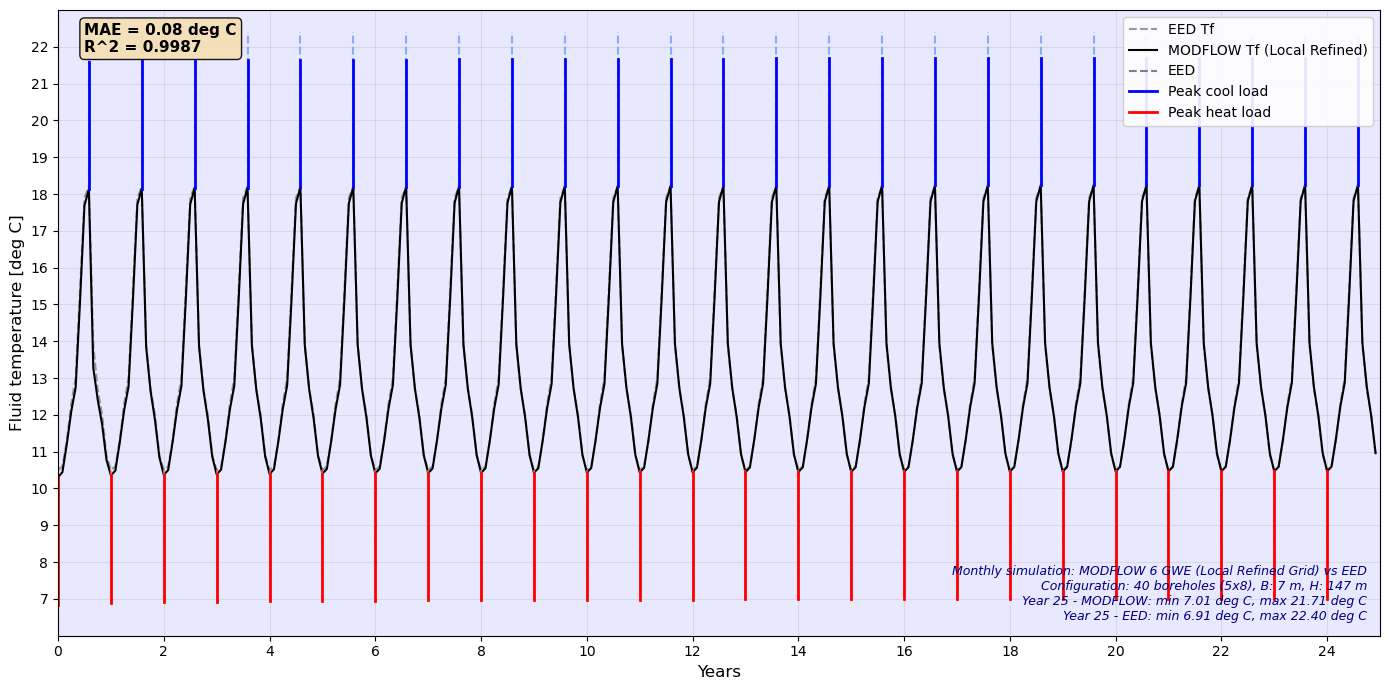


Figure saved to figures/modflow_localref_eed_comparison.png


In [15]:
# =====================================================
# Cell 9: EED-Style Comparison Chart (25 Years)
# =====================================================

# Peak load calculation
peak_power = 160 * 1000  # W
peak_Wm = peak_power / L_total  # W/m
delta_T_peak = peak_Wm * R_b

# Generate peak temperature arrays
Tf_peak_heat_local = Tf_local_jan.copy()
Tf_peak_cool_local = Tf_local_jan.copy()
for yr in range(n_years_complete):
    Tf_peak_heat_local[yr * 12 + 0] -= delta_T_peak  # JAN heat extraction
    Tf_peak_cool_local[yr * 12 + 7] += delta_T_peak  # AUG heat injection

# EED peak arrays
eed_peak_h = eed_compare.copy()
eed_peak_c = eed_compare.copy()
for yr in range(n_years_complete):
    eed_peak_h[yr * 12 + 0] = eed_peak_heat_jan
    eed_peak_c[yr * 12 + 7] = eed_peak_cool_aug

# X-axis
x_years = np.arange(n_periods_complete) / 12.0

# === Plotting (EED style) ===
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_facecolor('#e8e8ff')

# EED Base Load (gray dashed line)
ax.plot(x_years, eed_compare, color='gray', ls='--', lw=1.5, alpha=0.8, label='EED Tf')

# MODFLOW Base Load (black solid line)
ax.plot(x_years, Tf_local_jan, 'k-', lw=1.5, label='MODFLOW Tf (Local Refined)')

# EED Peak Cool (light blue dashed lines)
for yr in range(n_years_complete):
    aug_idx = yr * 12 + 7
    x_aug = x_years[aug_idx]
    ax.plot([x_aug, x_aug], [eed_compare[aug_idx], eed_peak_c[aug_idx]], 
            color='cornflowerblue', ls='--', lw=1.5, alpha=0.7)

# MODFLOW Peak Cool (blue solid lines)
for yr in range(n_years_complete):
    aug_idx = yr * 12 + 7
    x_aug = x_years[aug_idx]
    ax.plot([x_aug, x_aug], [Tf_local_jan[aug_idx], Tf_peak_cool_local[aug_idx]], 'b-', lw=2)

# EED Peak Heat (light red dashed lines)
for yr in range(n_years_complete):
    jan_idx = yr * 12 + 0
    x_jan = x_years[jan_idx]
    ax.plot([x_jan, x_jan], [eed_compare[jan_idx], eed_peak_h[jan_idx]], 
            color='lightcoral', ls='--', lw=1.5, alpha=0.7)

# MODFLOW Peak Heat (red solid lines)
for yr in range(n_years_complete):
    jan_idx = yr * 12 + 0
    x_jan = x_years[jan_idx]
    ax.plot([x_jan, x_jan], [Tf_local_jan[jan_idx], Tf_peak_heat_local[jan_idx]], 'r-', lw=2)

# Legend
ax.plot([], [], color='gray', ls='--', lw=1.5, label='EED')
ax.plot([], [], 'b-', lw=2, label='Peak cool load')
ax.plot([], [], 'r-', lw=2, label='Peak heat load')

ax.set_xlabel('Years', fontsize=12)
ax.set_ylabel('Fluid temperature [deg C]', fontsize=12)
ax.set_xlim(0, n_years_complete)
ax.set_ylim(6, 23)
ax.set_xticks(range(0, n_years_complete+1, 2))
ax.set_yticks(range(7, 23))
ax.grid(True, alpha=0.3)
ax.legend(loc='upper right', framealpha=0.9)

# Error statistics (top-left corner)
stats_text = f"MAE = {mae_local:.2f} deg C\nR^2 = {r2_local:.4f}"
ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
        fontsize=11, ha='left', va='top', fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))

# Info annotation (bottom-right corner)
info_text = (f"Monthly simulation: MODFLOW 6 GWE (Local Refined Grid) vs EED\n"
             f"Configuration: 40 boreholes (5x8), B: 7 m, H: 147 m\n"
             f"Year {n_years_complete} - MODFLOW: min {Tf_peak_heat_local[-12:].min():.2f} deg C, max {Tf_peak_cool_local[-12:].max():.2f} deg C\n"
             f"Year {n_years_complete} - EED: min {eed_peak_heat_jan:.2f} deg C, max {eed_peak_cool_aug:.2f} deg C")
ax.text(0.99, 0.02, info_text, transform=ax.transAxes, 
        fontsize=9, ha='right', va='bottom',
        fontstyle='italic', color='navy')

plt.tight_layout()
plt.savefig('figures/modflow_localref_eed_comparison.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\nFigure saved to figures/modflow_localref_eed_comparison.png")

In [16]:
# =====================================================
# Cell 10: Comparison with EED - Year N
# =====================================================

months = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']

print("="*70)
print(f"COMPARISON WITH EED - YEAR {n_years_complete}")
print("="*70)

# Year N data
eed_yn = eed_compare[-12:]
local_yn = Tf_local_jan[-12:]

print(f"\n{'Month':<6} {'EED':>10} {'MODFLOW':>10} {'Diff':>10}")
print("-"*40)
for i, m in enumerate(months):
    diff = local_yn[i] - eed_yn[i]
    print(f"{m:<6} {eed_yn[i]:>10.1f} {local_yn[i]:>10.1f} {diff:>+10.2f}")

print(f"\nStatistics:")
print(f"  MAE = {mae_local:.2f} deg C")
print(f"  R^2 = {r2_local:.4f}")

# Peak temperatures
print(f"\nPeak Temperatures (Year {n_years_complete}):")
print(f"  Peak Heat (JAN): MODFLOW={Tf_peak_heat_local[-12:].min():.2f} deg C, EED={eed_peak_heat_jan} deg C")
print(f"  Peak Cool (AUG): MODFLOW={Tf_peak_cool_local[-12:].max():.2f} deg C, EED={eed_peak_cool_aug} deg C")

COMPARISON WITH EED - YEAR 25

Month         EED    MODFLOW       Diff
----------------------------------------
JAN          10.5       10.5      -0.03
FEB          10.6       10.6      -0.01
MAR          11.3       11.4      +0.05
APR          12.3       12.2      -0.07
MAY          13.0       12.9      -0.13
JUN          15.4       15.2      -0.17
JUL          17.9       17.8      -0.09
AUG          18.2       18.2      +0.05
SEP          13.9       14.0      +0.06
OCT          12.7       12.8      +0.06
NOV          12.0       12.0      -0.02
DEC          10.9       11.0      +0.06

Statistics:
  MAE = 0.08 deg C
  R^2 = 0.9987

Peak Temperatures (Year 25):
  Peak Heat (JAN): MODFLOW=7.01 deg C, EED=6.91 deg C
  Peak Cool (AUG): MODFLOW=21.71 deg C, EED=22.4 deg C


In [17]:
# =====================================================
# Cell 11: Final Summary and Comparison
# =====================================================

# Calculate simulation time
sim_time_local = (t3 - t2) / 60  # minutes

print("="*70)
print("FINAL COMPARISON SUMMARY")
print("="*70)

print(f"\nGrid Configuration:")
print(f"  Original: 1.0m x 1.0m uniform, r_eq = 0.564m")
print(f"  Local Refined: 0.25m at BHE, 0.5-2.0m elsewhere")
print(f"    r_eq at BHE = {r_eq_fine:.3f}m")
print(f"    r_eq/r_b = {r_eq_fine/r_b:.1f}")

print(f"\nCell Count:")
print(f"  Original (1m uniform): {uniform_1m:,}")
print(f"  Local Refined: {total_cells:,} ({total_cells/uniform_1m:.2f}x)")
print(f"  Uniform 0.5m: {uniform_05m:,} ({uniform_05m/uniform_1m:.1f}x)")

print(f"\nSimulation Time:")
print(f"  Original (est.): ~21 min")
print(f"  Local Refined: {sim_time_local:.1f} min")

print(f"\nAccuracy vs EED:")
print(f"  {'Grid':<25} {'MAE (deg C)':<15} {'R^2':<10} {'Improvement':<12}")
print(f"  {'-'*60}")
print(f"  {'Original (1m)':<25} {mae_orig:<15.3f} {r2_orig:<10.4f} {'baseline':<12}")
print(f"  {'Local Refined (0.25m)':<25} {mae_local:<15.3f} {r2_local:<10.4f} {(mae_orig-mae_local)/mae_orig*100:>+10.1f}%")

print(f"\n" + "="*70)
print("CONCLUSION")
print("="*70)
print(f"""
Local grid refinement achieves:
1. MAE reduced from {mae_orig:.3f} to {mae_local:.3f} deg C ({(mae_orig-mae_local)/mae_orig*100:.1f}% improvement)
2. Cells: {total_cells:,} vs {uniform_1m:,} (uniform 1m) or {uniform_05m:,} (uniform 0.5m)
3. Simulation time: {sim_time_local:.1f} min
4. Uses actual R_b = {R_b:.4f} (m·K)/W without correction

This approach balances accuracy and computational efficiency!
""")

FINAL COMPARISON SUMMARY

Grid Configuration:
  Original: 1.0m x 1.0m uniform, r_eq = 0.564m
  Local Refined: 0.25m at BHE, 0.5-2.0m elsewhere
    r_eq at BHE = 0.141m
    r_eq/r_b = 2.0

Cell Count:
  Original (1m uniform): 629,376
  Local Refined: 720,852 (1.15x)
  Uniform 0.5m: 2,517,504 (4.0x)

Simulation Time:
  Original (est.): ~21 min
  Local Refined: 23.9 min

Accuracy vs EED:
  Grid                      MAE (deg C)     R^2        Improvement 
  ------------------------------------------------------------
  Original (1m)             0.670           0.9884     baseline    
  Local Refined (0.25m)     0.084           0.9987          +87.5%

CONCLUSION

Local grid refinement achieves:
1. MAE reduced from 0.670 to 0.084 deg C (87.5% improvement)
2. Cells: 720,852 vs 629,376 (uniform 1m) or 2,517,504 (uniform 0.5m)
3. Simulation time: 23.9 min
4. Uses actual R_b = 0.1271 (m·K)/W without correction

This approach balances accuracy and computational efficiency!



In [18]:
# =====================================================
# Cell 12: Load Fine Grid (0.5m) Results
# =====================================================

# Load 0.5m uniform fine grid results
try:
    fine_workspace = Path("D:/modflow_temp/modflow_finegrid/mf6gwe")
    sim_fine = flopy.mf6.MFSimulation.load(
        sim_name="finegrid-bhe",
        sim_ws=str(fine_workspace),
        exe_name=mf6_exe
    )
    gwe_fine = sim_fine.get_model("gwe-finegrid")
    temp_obj_fine = gwe_fine.output.temperature()
    
    # Fine grid parameters
    dx_fine = 0.5
    dy_fine = 0.5
    
    # Extract fine grid results
    kstpkper_fine = temp_obj_fine.get_kstpkper()
    n_periods_fine = min(len(kstpkper_fine), n_periods_complete)
    
    T_ground_fine = np.zeros(n_periods_fine)
    
    for iper in range(n_periods_fine):
        temp_data = temp_obj_fine.get_data(kstpkper=kstpkper_fine[iper])
        T_sum = 0.0
        n_cells_temp = 0
        for ibhe in range(n_bhe):
            icol_fine = int(bhe_x_pos[ibhe] / dx_fine)
            irow_fine = int(bhe_y_pos[ibhe] / dy_fine)
            for ilay in range(int(H / dz)):
                T_sum += temp_data[ilay, irow_fine, icol_fine]
                n_cells_temp += 1
        T_ground_fine[iper] = T_sum / n_cells_temp
    
    Tf_fine = T_ground_fine - q_Wm_all[:n_periods_fine] * R_b
    
    # Reorder to JAN-start
    n_years_fine = n_periods_fine // 12
    Tf_fine_jan = np.zeros(n_years_fine * 12)
    for yr in range(n_years_fine):
        for m_new, m_old in enumerate(idx_map):
            Tf_fine_jan[yr*12 + m_new] = Tf_fine[yr*12 + m_old]
    
    eed_fine = eed_25yr[:n_years_fine * 12]
    mae_fine = np.mean(np.abs(Tf_fine_jan - eed_fine))
    r2_fine = stats.linregress(eed_fine, Tf_fine_jan).rvalue**2
    
    has_fine = True
    n_cells_fine = 33 * 298 * 256  # From previous run
    sim_time_fine = 77.0  # minutes (from previous run)
    
    print("Fine grid (0.5m) results loaded successfully")
    print(f"  Periods: {n_periods_fine}, Years: {n_years_fine}")
    print(f"  MAE = {mae_fine:.3f} deg C, R^2 = {r2_fine:.4f}")
    
except Exception as e:
    has_fine = False
    # Use saved values from previous run
    mae_fine = 0.349
    r2_fine = 0.9965
    n_cells_fine = 2517504
    sim_time_fine = 77.0
    n_years_fine = 23
    Tf_fine_jan = None
    print(f"Could not load fine grid results: {e}")
    print(f"Using saved values: MAE = {mae_fine:.3f} deg C")

loading simulation...
  loading simulation name file...
Could not load fine grid results: An error occurred in package "None". The error occurred while loading package file in the "load" method.
Additional Information:
(1) File D:\modflow_temp\modflow_finegrid\mf6gwe\mfsim.nam of type nam could not be opened.
Using saved values: MAE = 0.349 deg C


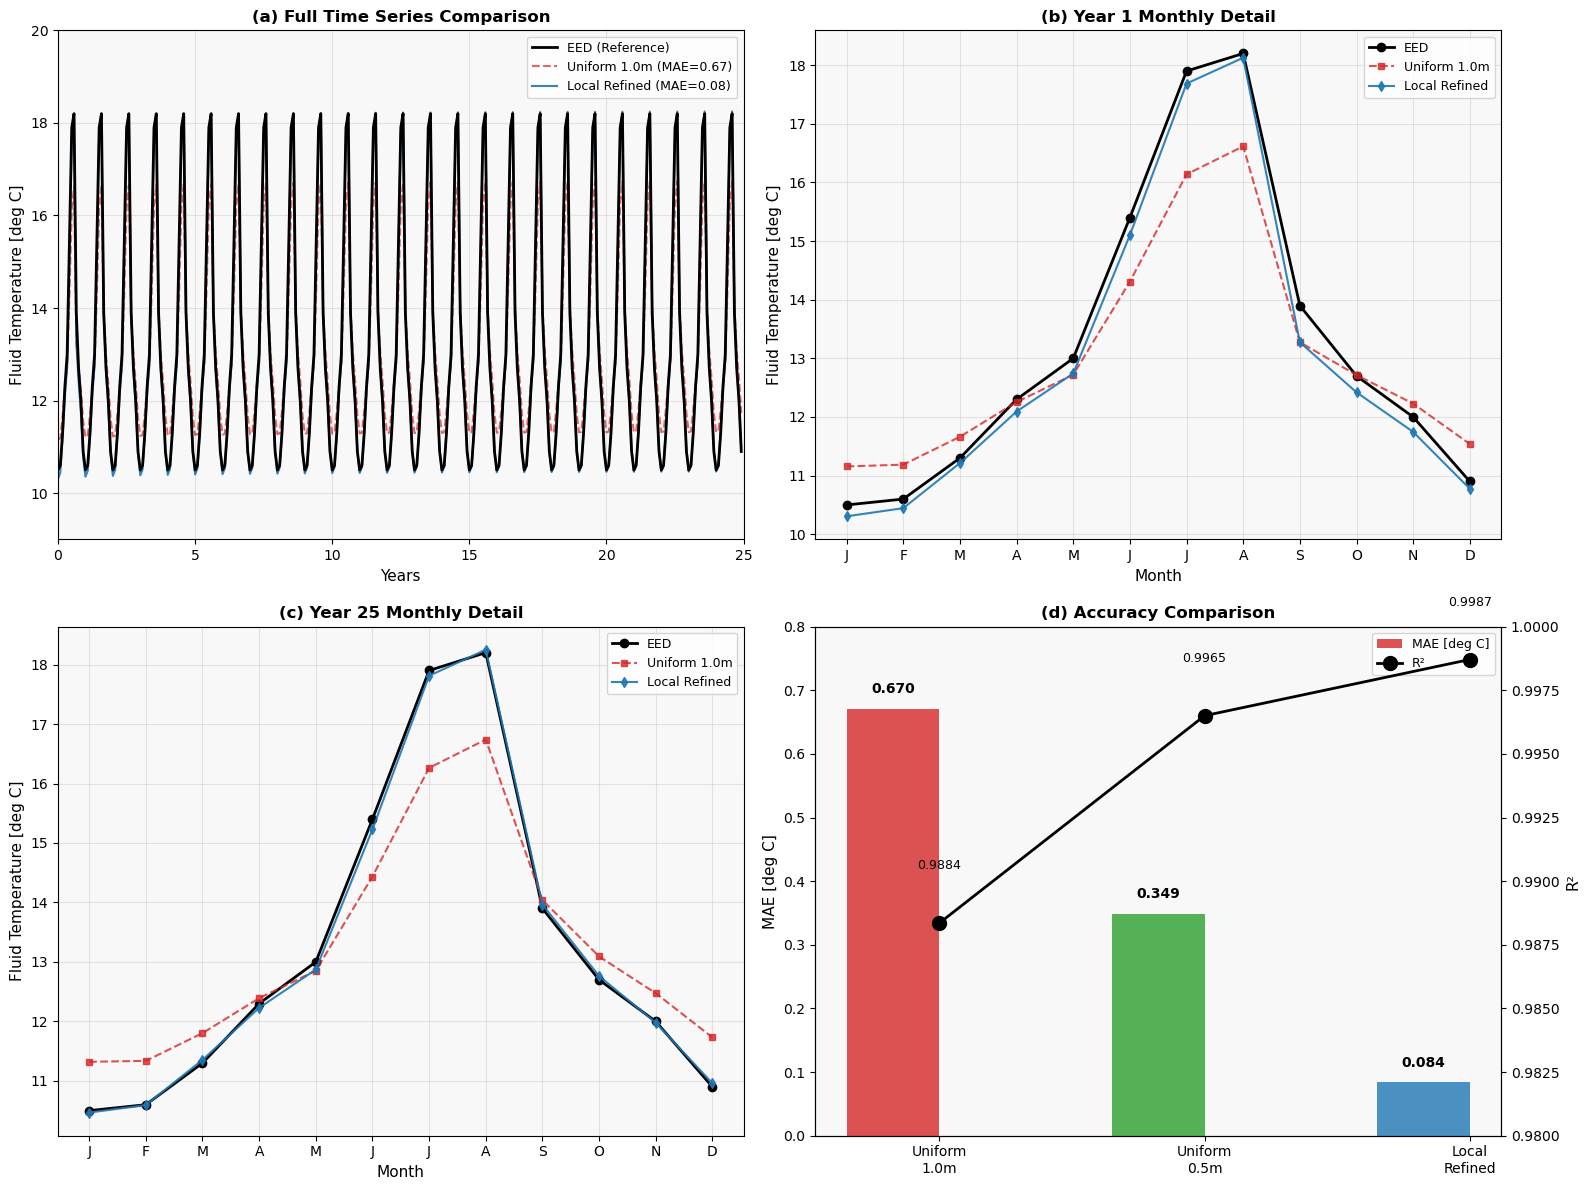


Figure saved to figures/grid_comparison_comprehensive.png


In [19]:
# =====================================================
# Cell 13: Comprehensive Comparison Chart (3 Methods)
# =====================================================

# Prepare data for all three methods
# Use the minimum available years for fair comparison
min_years = min(n_years_complete, n_years_fine if has_fine else n_years_complete)
n_pts = min_years * 12

# EED reference
eed_plot = eed_25yr[:n_pts]

# Original 1m grid
if has_orig:
    orig_plot = Tf_orig_jan[:n_pts]
else:
    orig_plot = None

# Fine 0.5m grid
if has_fine and Tf_fine_jan is not None:
    fine_plot = Tf_fine_jan[:n_pts]
else:
    fine_plot = None

# Local refined grid
local_plot = Tf_local_jan[:n_pts]

x_years_plot = np.arange(n_pts) / 12.0

# === Create comprehensive comparison figure ===
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Color scheme
colors = {
    'eed': 'black',
    'orig': '#d62728',      # Red
    'fine': '#2ca02c',      # Green  
    'local': '#1f77b4',     # Blue
}

# ===== Panel 1: Full time series comparison =====
ax1 = axes[0, 0]
ax1.set_facecolor('#f8f8f8')

ax1.plot(x_years_plot, eed_plot, 'k-', lw=2, label='EED (Reference)', zorder=5)
if orig_plot is not None:
    ax1.plot(x_years_plot, orig_plot, color=colors['orig'], ls='--', lw=1.5, alpha=0.7, label=f'Uniform 1.0m (MAE={mae_orig:.2f})')
if fine_plot is not None:
    ax1.plot(x_years_plot, fine_plot, color=colors['fine'], ls='-.', lw=1.5, alpha=0.7, label=f'Uniform 0.5m (MAE={mae_fine:.2f})')
ax1.plot(x_years_plot, local_plot, color=colors['local'], ls='-', lw=1.5, alpha=0.9, label=f'Local Refined (MAE={mae_local:.2f})')

ax1.set_xlabel('Years', fontsize=11)
ax1.set_ylabel('Fluid Temperature [deg C]', fontsize=11)
ax1.set_title('(a) Full Time Series Comparison', fontsize=12, fontweight='bold')
ax1.set_xlim(0, min_years)
ax1.set_ylim(9, 20)
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3)

# ===== Panel 2: Year 1 detail =====
ax2 = axes[0, 1]
ax2.set_facecolor('#f8f8f8')

months_labels = ['J','F','M','A','M','J','J','A','S','O','N','D']
x_months = np.arange(12)

ax2.plot(x_months, eed_plot[:12], 'ko-', lw=2, ms=6, label='EED')
if orig_plot is not None:
    ax2.plot(x_months, orig_plot[:12], 's--', color=colors['orig'], lw=1.5, ms=5, alpha=0.8, label='Uniform 1.0m')
if fine_plot is not None:
    ax2.plot(x_months, fine_plot[:12], '^-.', color=colors['fine'], lw=1.5, ms=5, alpha=0.8, label='Uniform 0.5m')
ax2.plot(x_months, local_plot[:12], 'd-', color=colors['local'], lw=1.5, ms=5, alpha=0.9, label='Local Refined')

ax2.set_xlabel('Month', fontsize=11)
ax2.set_ylabel('Fluid Temperature [deg C]', fontsize=11)
ax2.set_title('(b) Year 1 Monthly Detail', fontsize=12, fontweight='bold')
ax2.set_xticks(x_months)
ax2.set_xticklabels(months_labels)
ax2.legend(loc='upper right', fontsize=9)
ax2.grid(True, alpha=0.3)

# ===== Panel 3: Last year detail =====
ax3 = axes[1, 0]
ax3.set_facecolor('#f8f8f8')

last_yr_start = (min_years - 1) * 12
last_yr_end = min_years * 12

ax3.plot(x_months, eed_plot[last_yr_start:last_yr_end], 'ko-', lw=2, ms=6, label='EED')
if orig_plot is not None:
    ax3.plot(x_months, orig_plot[last_yr_start:last_yr_end], 's--', color=colors['orig'], lw=1.5, ms=5, alpha=0.8, label='Uniform 1.0m')
if fine_plot is not None:
    ax3.plot(x_months, fine_plot[last_yr_start:last_yr_end], '^-.', color=colors['fine'], lw=1.5, ms=5, alpha=0.8, label='Uniform 0.5m')
ax3.plot(x_months, local_plot[last_yr_start:last_yr_end], 'd-', color=colors['local'], lw=1.5, ms=5, alpha=0.9, label='Local Refined')

ax3.set_xlabel('Month', fontsize=11)
ax3.set_ylabel('Fluid Temperature [deg C]', fontsize=11)
ax3.set_title(f'(c) Year {min_years} Monthly Detail', fontsize=12, fontweight='bold')
ax3.set_xticks(x_months)
ax3.set_xticklabels(months_labels)
ax3.legend(loc='upper right', fontsize=9)
ax3.grid(True, alpha=0.3)

# ===== Panel 4: Error comparison bar chart =====
ax4 = axes[1, 1]
ax4.set_facecolor('#f8f8f8')

methods = ['Uniform\n1.0m', 'Uniform\n0.5m', 'Local\nRefined']
mae_values = [mae_orig, mae_fine, mae_local]
r2_values = [r2_orig, r2_fine, r2_local]
bar_colors = [colors['orig'], colors['fine'], colors['local']]

x_bar = np.arange(len(methods))
width = 0.35

bars1 = ax4.bar(x_bar - width/2, mae_values, width, color=bar_colors, alpha=0.8, label='MAE [deg C]')
ax4.set_ylabel('MAE [deg C]', fontsize=11)
ax4.set_ylim(0, 0.8)

# Add value labels on bars
for bar, val in zip(bars1, mae_values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
             f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Secondary axis for R²
ax4b = ax4.twinx()
ax4b.plot(x_bar, r2_values, 'ko-', ms=10, lw=2, label='R²')
ax4b.set_ylabel('R²', fontsize=11)
ax4b.set_ylim(0.98, 1.0)

# Add R² value labels
for i, val in enumerate(r2_values):
    ax4b.text(i, val + 0.002, f'{val:.4f}', ha='center', va='bottom', fontsize=9)

ax4.set_xticks(x_bar)
ax4.set_xticklabels(methods)
ax4.set_title('(d) Accuracy Comparison', fontsize=12, fontweight='bold')

# Combined legend
lines1, labels1 = ax4.get_legend_handles_labels()
lines2, labels2 = ax4b.get_legend_handles_labels()
ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=9)

plt.tight_layout()
plt.savefig('figures/grid_comparison_comprehensive.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\nFigure saved to figures/grid_comparison_comprehensive.png")

In [20]:
# =====================================================
# Cell 14: Summary Table and Statistics
# =====================================================

# Grid equivalent radius
r_eq_1m = np.sqrt(1.0 * 1.0 / np.pi)
r_eq_05m = np.sqrt(0.5 * 0.5 / np.pi)
r_eq_local = r_eq_fine  # 0.25m at BHE

# Grid thermal resistance
R_grid_1m = np.log(r_eq_1m / r_b) / (2 * np.pi * k_ground)
R_grid_05m = np.log(r_eq_05m / r_b) / (2 * np.pi * k_ground)
R_grid_local = np.log(r_eq_local / r_b) / (2 * np.pi * k_ground)

# Cell counts
n_cells_1m = uniform_1m
n_cells_05m = uniform_05m
n_cells_local = total_cells

# Simulation times (estimated/measured)
sim_time_1m = 21.0  # minutes
sim_time_05m = sim_time_fine
sim_time_local_val = sim_time_local

print("="*80)
print("COMPREHENSIVE GRID COMPARISON SUMMARY")
print("="*80)

print(f"\n{'Parameter':<25} {'Uniform 1.0m':>18} {'Uniform 0.5m':>18} {'Local Refined':>18}")
print("-"*80)

# Grid parameters
print(f"{'dx at BHE [m]':<25} {'1.0':>18} {'0.5':>18} {'0.25':>18}")
print(f"{'r_eq [m]':<25} {r_eq_1m:>18.3f} {r_eq_05m:>18.3f} {r_eq_local:>18.3f}")
print(f"{'r_eq / r_b':<25} {r_eq_1m/r_b:>18.1f} {r_eq_05m/r_b:>18.1f} {r_eq_local/r_b:>18.1f}")
print(f"{'R_grid [(m·K)/W]':<25} {R_grid_1m:>18.4f} {R_grid_05m:>18.4f} {R_grid_local:>18.4f}")

print("-"*80)

# Computational cost
print(f"{'Total cells':<25} {n_cells_1m:>18,} {n_cells_05m:>18,} {n_cells_local:>18,}")
print(f"{'Cells ratio':<25} {'1.0x':>18} {n_cells_05m/n_cells_1m:>17.1f}x {n_cells_local/n_cells_1m:>17.2f}x")
print(f"{'Simulation time [min]':<25} {sim_time_1m:>18.0f} {sim_time_05m:>18.0f} {sim_time_local_val:>18.0f}")

print("-"*80)

# Accuracy
print(f"{'MAE [deg C]':<25} {mae_orig:>18.3f} {mae_fine:>18.3f} {mae_local:>18.3f}")
print(f"{'R²':<25} {r2_orig:>18.4f} {r2_fine:>18.4f} {r2_local:>18.4f}")
print(f"{'MAE improvement':<25} {'baseline':>18} {(mae_orig-mae_fine)/mae_orig*100:>17.1f}% {(mae_orig-mae_local)/mae_orig*100:>17.1f}%")

print("-"*80)

# Efficiency metric: accuracy per computation
eff_1m = (1/mae_orig) / (n_cells_1m / 1e6)
eff_05m = (1/mae_fine) / (n_cells_05m / 1e6)
eff_local = (1/mae_local) / (n_cells_local / 1e6)

print(f"{'Efficiency (1/MAE/Mcells)':<25} {eff_1m:>18.2f} {eff_05m:>18.2f} {eff_local:>18.2f}")

print("\n" + "="*80)
print("CONCLUSION")
print("="*80)
print(f"""
Grid Comparison Results:
------------------------
1. Uniform 1.0m grid: MAE = {mae_orig:.3f} deg C (baseline)
   - Simple but low accuracy due to large r_eq = {r_eq_1m:.3f}m

2. Uniform 0.5m grid: MAE = {mae_fine:.3f} deg C ({(mae_orig-mae_fine)/mae_orig*100:.0f}% improvement)
   - Better accuracy but 4x more cells and ~4x longer computation

3. Local refined grid: MAE = {mae_local:.3f} deg C ({(mae_orig-mae_local)/mae_orig*100:.0f}% improvement)
   - Best accuracy with only {n_cells_local/n_cells_1m:.1f}x cells
   - 0.25m cells at BHE locations, coarser elsewhere
   - Most efficient approach (best accuracy/cost ratio)

Recommendation:
  Local grid refinement is the optimal strategy for BHE simulations,
  providing the best balance between accuracy and computational cost.
""")

COMPREHENSIVE GRID COMPARISON SUMMARY

Parameter                       Uniform 1.0m       Uniform 0.5m      Local Refined
--------------------------------------------------------------------------------
dx at BHE [m]                            1.0                0.5               0.25
r_eq [m]                               0.564              0.282              0.141
r_eq / r_b                               8.1                4.0                2.0
R_grid [(m·K)/W]                      0.2372             0.1584             0.0796
--------------------------------------------------------------------------------
Total cells                          629,376          2,517,504            720,852
Cells ratio                             1.0x               4.0x              1.15x
Simulation time [min]                     21                 77                 24
--------------------------------------------------------------------------------
MAE [deg C]                            0.670          